# Анализ лояльности пользователей Яндекс Афиши

- Автор: Пужонков Антон. 
- Дата: 2025-11-22.

Цель проекта: провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно.

В рамках подготовки к проекту, была изучена БД "Афиши". Результаты знакомства с данными:

- В базе данных представлена информация о покупках билетов в 353 городах в 81 регионе России и Казахстана (встречаются два значения в поле 'currency_code': rub - российский рубль и kzt - казахстанский тенге).
- Данные представлены за период июнь-октябрь 2024 года.
- 22 000 пользователей совершили 292 034 заказа, купили 804 410 билетов.
- ~ 99.6% заказов приходится на мобильные устройства (~ 79.7%) и компьютеры (~ 19,9 %). В данном проекте будут рассматриваться заказы именно с этих устройств.
- Также, из-за малого количества заказов билетов на кинопоказы ('event_type_main' = фильм) было решено не использватель эту категорию в анализе.
- После фильтрации по вышеперечисленным параметрам, у нас должны остаться: 21 933 пользователя, 290 611 заказов, 800 433 купленных билета.
- Самые популярные мероприятия по количеству заказов с возрастным ограничением 16+ и 12+, но по количеству проданных билетов: 16+ и 0.
- В базе данных было около 6150 заказов с нулевой или отрицательной выручкой ('revenue'). Также в этом поле встречаются аномально высокие значения.

<a id="cont" class="anchor"></a>

С О Д Е Р Ж А Н И Е:

<a href="#chapter10" class="anchor">1. Загрузка данных и их предобработка</a>

<a href="#chapter20" class="anchor">2. Предобработка данных</a>

<a href="#chapter30" class="anchor">3. Создание профиля пользователя</a>

<a href="#chapter40" class="anchor">4. Исследовательский анализ данных</a>

<a href="#chapter41" class="anchor">4.1. Исследование признаков первого заказа и их связи с возвращением на платформу</a>

<a href="#chapter42" class="anchor">4.2. Исследование поведения пользователей через показатели выручки и состава заказа</a>

<a href="#chapter43" class="anchor">4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки</a>

<a href="#chapter44" class="anchor">4.4. Корреляционный анализ количества покупок и признаков пользователя</a>

<a href="#chapter50" class="anchor">5. Общий вывод и рекомендации</a>

<a href="#chapter60" class="anchor">6. Финализация проекта и публикация в Git</a>

---

## Этапы выполнения проекта
<a id="chapter10" class="anchor"></a>
### 1. Загрузка данных и их предобработка

**Задача 1.1:**

Установка и импорт необходимых библиотек:

In [1]:
%%capture
# Код выше скрывает бесполезную для заказчика информацию

!pip install dotenv
!pip install sqlalchemy
!pip install psycopg2
!pip install phik

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from phik import phik_matrix
from sqlalchemy import create_engine
from matplotlib.ticker import MultipleLocator as MLoc
from dotenv import load_dotenv 
import os

In [2]:
load_dotenv(dotenv_path='.env')
# Конфиг подключения к БД:
db_config = {'user': os.getenv('USER'), # имя пользователя
             'pwd': os.getenv('PASS'), # пароль
             'host': os.getenv('HOST'),
             'port': os.getenv('PORT'), # порт подключения
             'db': os.getenv('DB') # название базы данных
             }
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

In [3]:
# Напишем запрос к БД "Афиши" с фильтрацией
# по оговоренным в введении правилам:
query = '''
SELECT p.user_id, 
       p.device_type_canonical, 
       p.order_id, 
       p.created_dt_msk AS order_dt,
       p.created_ts_msk,
       p.currency_code,
       p.revenue,
       p.tickets_count,
       EXTRACT(DAY FROM 
       (p.created_dt_msk - LAG(p.created_dt_msk) 
       OVER(PARTITION BY p.user_id ORDER BY p.created_dt_msk)))::int 
       AS days_since_prev,
       e.event_id,
       e.event_name_code AS event_name,
       e.event_type_main,
       p.service_name,
       r.region_name,
       c.city_name

FROM afisha.purchases as p 
     JOIN afisha.events as e USING (event_id)
     JOIN afisha.city as c USING (city_id)
     JOIN afisha.regions as r USING (region_id)

WHERE p.device_type_canonical IN ('desktop', 'mobile')
      AND
      e.event_type_main != 'фильм'
      
ORDER BY user_id, created_ts_msk
''' 

In [4]:
# Результаты запроса сохраняем в датасет:
df = pd.read_sql_query(query, con=engine)

Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Для корректности рассчетов, нужно привести значения к российскому рублю. Для этого загрузим датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год:

In [5]:
exch_rate24_kzt_rub = (
pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'))

In [6]:
display(exch_rate24_kzt_rub.head(3))
display(exch_rate24_kzt_rub.tail(3))
display(exch_rate24_kzt_rub.info())

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt


,data,nominal,curs,cdx
354,2024-12-29,100,19.486,kzt
355,2024-12-30,100,19.486,kzt
356,2024-12-31,100,19.486,kzt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

Датасет охватывает 357 дней 2024 года, начиная с 10 января. 10 явнаря 100 тенге по официальному курсу менялись на 19.9391 руб. Чтобы привести kzt в rub, нужно значение в тенге поделить на 100 и умножить на значение столбца 'curs'.

Столбец 'data' в фрейме - строка. Необходимо привести "дату" к datetime:

In [7]:
exch_rate24_kzt_rub['data'] = pd.to_datetime(exch_rate24_kzt_rub['data'])

**Задача 1.2:** 

Выгрузим первые несколько строк полученного датасета и выведем информацию о нем:

In [8]:
display(df.head(4))
df.info(memory_usage='deep')

,user_id,device_type_canonical,order_id,order_dt,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

- Как мы и ожидали, получен датасет с 290 611 заказами (см. введение).
- Единственный столбец с пропусками: 'days_since_prev'. Пропуск на данном этапе обозначает первую (либо единственную) покупку пользователя, поэтому число пропусков в этом столбце равно числу уникальных покупателей 21 993 (см. введение).
- Столбцы 'order_id', 'revenue', 'tickets_count' и 'event_id' представлены числами с максимальной разрядностю int(float)64. Проверим, возможно ли понизить разрядность.
- Столбец 'days_since_prev' представлен числами с плавающей точкой, не смотря на то, что в sql-запросе к БД явно указывался как int. Это следствие того, что числовые значения с пропусками могут быть представлены только как float.
- Формат datetime64[ns] является оптимальным для pandas по производительности и памяти. Уменьшение разрядности может привести потере функциональности некоторых pandas-операций.

В этом разделе создали датасет из запроса к БД "Афиши". Получена выборка 290 611 заказов билетов в сервисе. Наименование столбцов в snake_case не требует дополнительных действий. Пропуски только в столбце 'days_since_prev', их количество равно количеству уникальных пользователей сервиса в период июнь-октябрь 2024. Это объясняется тем, что пропуск обозначет первую (либо единственную) покупку пользователя.

<a href="#cont" class="anchor">[Вернуться к содержанию]</a>

---
<a id="chapter20" class="anchor"></a>
###  2. Предобработка данных

Проверим датасет на явные дубликаты:

In [9]:
# Сбор статистики:
rows_before = df.shape[0] # кол-во строк до обработки

# Проверка на явные дубликаты:
obv_duplicates = df.duplicated(keep='first')
df = df.loc[~obv_duplicates]

print(
    f"Было найдено и удалено "
    f"{rows_before - df.shape[0]} строк "
    f"({round((rows_before-df.shape[0]) / rows_before * 100, 1)} %)"
)

Было найдено и удалено 0 строк (0.0 %)


Проверим датасет на неявные дубликаты:

Искать будем по совпадению пользователя, даты заказа и мероприятия.

In [10]:
df['test_dupl'] = (
    df['user_id'].astype(str) +
    df['order_dt'].astype(str) +
    df['event_id'].astype(str)
)

dupl_estab = df.duplicated(subset=['test_dupl'], keep='first')
potential_duplicates = df[dupl_estab]
print(f'Найдено: {potential_duplicates.shape[0]} дубликатов')

Найдено: 99198 дубликатов


Огромное количество строк! Добавим так же количество билетов и тип устройства, с которого сделан заказ:

In [11]:
df['test_dupl'] = (
    df['user_id'].astype(str) +
    df['order_dt'].astype(str) +
    df['event_id'].astype(str) +
    df['device_type_canonical'].astype(str) +
    df['tickets_count'].astype(str)
)

dupl_estab = df.duplicated(subset=['test_dupl'], keep='first')
potential_duplicates = df[dupl_estab]
print(f'Найдено: {potential_duplicates.shape[0]} дубликатов')

Найдено: 51585 дубликатов


Заменим дату заказа на время заказа:

In [12]:
df['test_dupl'] = (
    df['user_id'].astype(str) +
    df['created_ts_msk'].astype(str) +
    df['event_id'].astype(str) +
    df['device_type_canonical'].astype(str) +
    df['tickets_count'].astype(str)
)

dupl_orders = df.duplicated(subset=['test_dupl'], keep='first')
potential_duplicates = df[dupl_orders]
print(f'Найдено: {potential_duplicates.shape[0]} дубликатов')

Найдено: 40 дубликатов


In [13]:
print(f'Строк до очистки: {df.shape[0]}')
# Удалим найденные дубликаты из датасета и выведем на экран результат работы:
df = df.loc[~dupl_orders] 
print(f'Строк после очистки: {df.shape[0]}')

Строк до очистки: 290611
Строк после очистки: 290571


**Задача 2.1:**

Так как данные о выручке сервиса представлены в российских рублях и казахстанских тенге, приведем выручку к единой валюте — российскому рублю. Результаты преобразования сохраним в новый столбец 'revenue_rub':

Присоединим столбец 'curs' к датасету с заказами:

In [14]:
df = pd.merge(
    df, exch_rate24_kzt_rub[['data', 'curs']], 
    left_on = 'order_dt',
    right_on = 'data',
    how = 'left')

Создадим новый столбец 'revenue_rub':

- в него запишутся пересчитанные на рубли значения, если код валюты 'kzt'
- если код валюты покупки не 'kzt' в 'revenue_rub' запишутся значения 'revenue'

In [15]:
df['revenue_rub'] = df.apply(
    lambda row: (row['revenue'] / 100 * row['curs'] 
                 if row['currency_code'] == 'kzt' 
                 else row['revenue']),
    axis=1
)

Проверим результат:

In [16]:
print('Несколько строк, где рассчеты были в тенге:')
display(df.loc[df['currency_code']== 'kzt',
               ['revenue','curs','revenue_rub']].head(3))

print('\nНесколько строк, где рассчеты были в рублях:')
display(df.loc[df['currency_code']== 'rub',
               ['revenue','revenue_rub']].head(3))

Несколько строк, где рассчеты были в тенге:


,revenue,curs,revenue_rub
70,518.10,19.0125,98.503762
89,347.18,18.9330,65.731589
96,328.77,18.5991,61.148261



Несколько строк, где рассчеты были в рублях:


,revenue,revenue_rub
0,1521.94,1521.94
1,289.45,289.45
2,1258.57,1258.57


Удалим временный столбец 'curs' и датафрейм с курсами:

In [17]:
df.drop('curs', axis=1, inplace=True)
del exch_rate24_kzt_rub

# Сбор статистики:
mem_use_bef = df.memory_usage(deep=True).sum()

---

**Задача 2.2:**

Проверим данные на пропущенные значения:

In [18]:
# Абсолютное значение пропусков
missing_data = df.isnull().sum() 
# Значение пропусков в процентах
missing_data_percent = round(missing_data / len(df) * 100, 1) 
# Создаем датафрейм с рассчитанными значениями...
df_misses = pd.DataFrame({
    'Количество пропусков' : missing_data,
    'Процент пропусков' : missing_data_percent})
df_misses = df_misses.sort_values(by='Количество пропусков', ascending = False)
# ... и выводим на экран те его строки, 
# в которых количество пропусков больше нуля:
display(df_misses[df_misses['Количество пропусков'] > 0])

,Количество пропусков,Процент пропусков
days_since_prev,21933,7.5


Пропуски есть только в столбце 'days_since_prev', их количество равно количеству уникальных пользователей сервиса в период июнь-октябрь 2024. Это объясняется тем, что пропуск обозначет первую (либо единственную) покупку пользователя.

Преобразуем данные в столбцах:

- Столбцы 'order_id', 'revenue', 'tickets_count' и 'event_id' представлены числами с максимальной разрядностю int(float)64. Проверим, возможно ли понизить разрядность.
- Столбец 'days_since_prev' представлен числами с плавающей точкой, не смотря на то, что в sql-запросе к БД явно указывался как int. Это следствие того, что числовые значения с пропусками могут быть представлены только как float.
- Формат datetime64[ns] является оптимальным для pandas по производительности и памяти. Уменьшение разрядности может привести к потере функциональности некоторых pandas-операций. Не будем ее производить.
- revenue_rub - результат операций деления и умножения. Для сохранения точности понижение разрядности не производится.

In [19]:
# Сбор статистики:
mem_use_bef = df.memory_usage(deep=True).sum()

df['order_id'] = pd.to_numeric(df['order_id'], downcast='integer')
df['revenue'] = pd.to_numeric(df['revenue'], downcast='float')
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')
df['event_id'] = pd.to_numeric(df['event_id'], downcast='integer')
print('   Результат работы\n   downcast-команд\nпонижения разрядности:')
print('----------------------')
for col in ['order_id', 'revenue', 'tickets_count', 'event_id']:
    print(f'{col:<15}{df[col].dtype}')
    
# Сбор статистики:
mem_use_aft = df.memory_usage(deep=True).sum()
print(f'\n  Понижение разрядности\n сократило использование\nпамяти на ~'
      f'{round((mem_use_bef-mem_use_aft)/(1024**2),1)} Мб ('
      f'{round(((1-mem_use_aft/mem_use_bef)*100),2)} %)')

   Результат работы
   downcast-команд
понижения разрядности:
----------------------
order_id       int32
revenue        float64
tickets_count  int8
event_id       int32

  Понижение разрядности
 сократило использование
памяти на ~4.2 Мб (1.71 %)


Проверим уникальные значения в категориальных данных. Возможно, среди них найдутся те, что указывают на отсутствие информации:

In [20]:
%%capture
# Ячейка скрыта из-за большого объема информации.
# При необходимости изучения результата выполнения сотрите код выше 
# и перезапустите проект (Kernel -> Restart & Run All)

print('Тип мероприятий:')
event_types = sorted(str(x) for x in df['event_type_main'].unique())
for _ in event_types:
    print(_)
    
print('\nБилетные операторы:')
services = sorted(str(x) for x in df['service_name'].unique())
for _ in services:
    print(_)
    
print('\nРегионы:')
regions = sorted(str(x) for x in df['region_name'].unique())
for _ in regions:
    print(_)
    
print('\nГорода:')
cities = sorted(str(x) for x in df['city_name'].unique())
for _ in regions:
    print(_)

- В 'event_type_main' есть категория "другое". Это название не указывает на отсутствие информации.
- В названиях регионов, городов и билетных операторов нет "подозрительных" названий.

В данных было около 6 150 (~ 2.12%) строк с нулевой или отрицательной выручкой. Предполагаем, что это возвраты или подарки. Целесообразно не использовать соответствующие строки для целей нашего исследования.

In [21]:
print(f'Строк до очистки: {df.shape[0]}')
df = df[df['revenue'] > 0]
print(f'Строк после очистки: {df.shape[0]}')

Строк до очистки: 290571
Строк после очистки: 284665


Проверим распределение выручки с одного заказа и количества билетов в одном заказе:

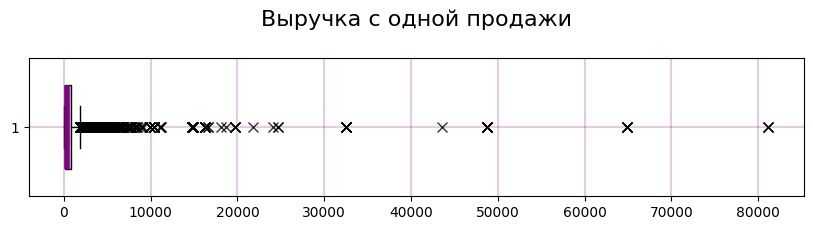

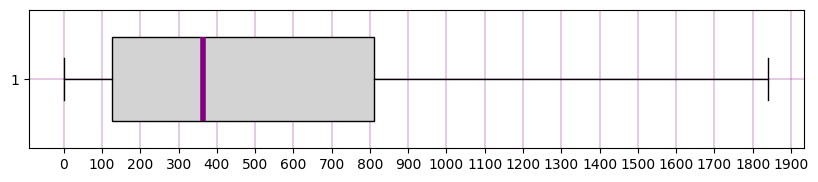

count    284665.000000
mean        567.116163
std         880.859576
min           0.020000
50%         364.370000
90%        1303.260000
95%        1645.200000
99%        2628.421739
max       81174.540000
Name: revenue_rub, dtype: float64

In [22]:
plt.figure(figsize=(10, 1.8))

plt.boxplot(
    df['revenue_rub'],
    vert=False,
    patch_artist=True,
    widths = 0.6,
    boxprops=dict(facecolor='lightgray', color='black'),
    medianprops=dict(color='purple', linewidth=4),
    flierprops=dict(marker='x',
                    alpha=0.8, 
                    markerfacecolor='lightgray', 
                    markersize=7)
)

plt.gca().xaxis.set_major_locator(MLoc(10000))

plt.title('Выручка c одной продажи\n', fontsize=16)
plt.grid(axis='both', alpha=1, color='purple', linewidth = 0.3)
plt.show()

plt.figure(figsize=(10, 1.8))

plt.boxplot(
    df['revenue_rub'],
    sym = '',
    vert=False,
    patch_artist=True,
    widths = 0.6,
    boxprops=dict(facecolor='lightgray', color='black'),
    medianprops=dict(color='purple', linewidth=4)
)

plt.gca().xaxis.set_major_locator(MLoc(100))
plt.xlabel('', fontsize=14)
plt.grid(axis='both', alpha=1, color='purple', linewidth = 0.3)

plt.show()

df['revenue_rub'].describe(
    percentiles = [0.9, 0.95, 0.99])

Обнаружены выбросы в поле 'revenue_rub'. Отфильтруем данные по 99 перцентилю этого показателя:

In [23]:
print(f'Строк до очистки: {df.shape[0]}')
rev_rub_q_99 = df['revenue_rub'].quantile(0.99)
df = df[(df['revenue_rub'] < rev_rub_q_99)]
print(f'Строк после очистки: {df.shape[0]}')

Строк до очистки: 284665
Строк после очистки: 281658


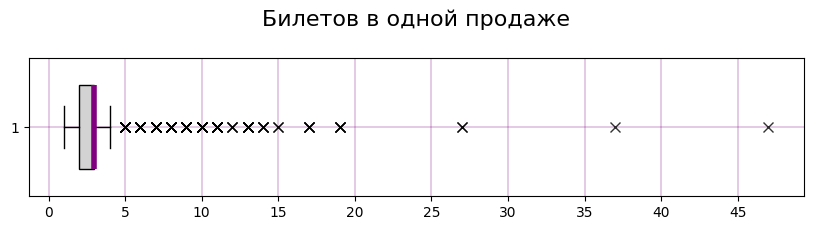

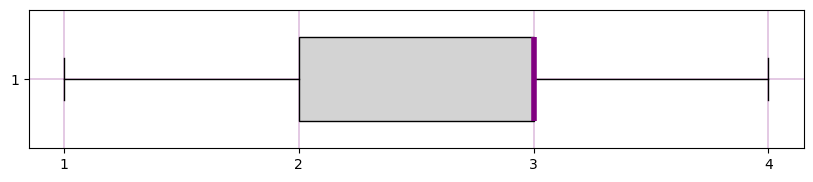

count    281658.000000
mean          2.743959
std           1.157521
min           1.000000
50%           3.000000
90%           4.000000
95%           5.000000
99%           6.000000
99.9%         6.000000
max          47.000000
Name: tickets_count, dtype: float64

In [24]:
plt.figure(figsize=(10, 1.8))

plt.boxplot(
    df['tickets_count'],
    vert=False,
    patch_artist=True,
    widths = 0.6,
    boxprops=dict(facecolor='lightgray', color='black'),
    medianprops=dict(color='purple', linewidth=4),
    flierprops=dict(marker='x',
                    alpha=0.8, 
                    markerfacecolor='lightgray', 
                    markersize=7)
)

plt.gca().xaxis.set_major_locator(MLoc(5))

plt.title('Билетов в одной продаже\n', fontsize=16)
plt.grid(axis='both', alpha=1, color='purple', linewidth = 0.3)
plt.show()

plt.figure(figsize=(10, 1.8))

plt.boxplot(
    df['tickets_count'],
    sym = '',
    vert=False,
    patch_artist=True,
    widths = 0.6,
    boxprops=dict(facecolor='lightgray', color='black'),
    medianprops=dict(color='purple', linewidth=4)
)

plt.gca().xaxis.set_major_locator(MLoc(1))
plt.xlabel('', fontsize=14)
plt.grid(axis='both', alpha=1, color='purple', linewidth = 0.3)

plt.show()

df['tickets_count'].describe(
    percentiles = [0.9, 0.95, 0.99, 0.999])

Видно небольшое количество заказов (0,1% ~280 заказов), в которых количество билетов >=6. Предполагаем, что это корпоративные разовые закупки, неактуальные для целей нашего исследования. Аналогично, исключим такие заказы из выборки:

In [25]:
print(f'Строк до очистки: {df.shape[0]}')
tickets_cnt_q_99 = df['tickets_count'].quantile(0.99)
df = df[(df['tickets_count'] < tickets_cnt_q_99)]
print(f'Строк после очистки: {df.shape[0]}')

Строк до очистки: 281658
Строк после очистки: 277565


В этом разделе для точности расчетов привели значения выручки к единой валюте (российский рубль) и записали результаты в новый столбец 'revenue_rub.

Понизили разрядность некоторых числовых столбцов, что позволило сократить использование памяти на ~ 1.92%.

Проверили категориальные данные на наличие значений, указывающих на отсутствие информации (не найдено).

Проанализировали и убрали нетипичные для целевой аудитории данные:

- Заказы с нулевой или отрицательной выручкой (возможно, возраты и подарки);
- 1% заказов с максимальной выручкой и количеством билетов в заказе (возможно, корпоративные разовые покупки).

Строк до обработки: 290 611, после 277 565 (меньше примерно на 4.49%).

<a href="#cont" class="anchor">[Вернуться к содержанию]</a>

---
<a id="chapter30" class="anchor"></a>
### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Необходимо построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** 

Построим профиль пользователя — для каждого пользователя найдем:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

А также добавим два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

---


In [26]:
# Создаем сводную таблицу с профилем пользователя
user_profile = df.groupby('user_id').agg(
    first_order = ('order_dt', 'first'),
    last_order = ('order_dt', 'last'),
    first_device = ('device_type_canonical', 'first'),
    first_region = ('region_name', 'first'),
    first_service = ('service_name', 'first'),
    first_event_type = ('event_type_main', 'first'),
    total_orders = ('order_id', 'count'),
    avg_revenue_rub = ('revenue_rub', 'mean'),
    avg_tickets = ('tickets_count', 'mean'),
    avg_days_between_orders = ('days_since_prev', 'mean')
).reset_index()

# Добавим два бинарных признака: 
# пользователь совершил 2 и более заказов,
# пользователь совершил 5 и более заказов
user_profile['is_two'] = (
    user_profile['total_orders'] >= 2).astype('int8')
user_profile['is_five'] = (
    user_profile['total_orders'] >= 5).astype('int8')

**Задача 3.2.**

Проверим первые строки получившихся профилей:

In [27]:
user_profile.head(6)

,user_id,first_order,last_order,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.000000,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.000000,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.000000,1,0
5,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,Лови билет!,концерты,13,1175.808462,3.307692,0.083333,1,1


Рассчитаем:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

In [28]:
print(f'Общее число пользователей в выборке: {user_profile.shape[0]}')
print(f'Общее число заказов в выборке: {user_profile.total_orders.sum()}')
print(f'Средняя выручка с одного заказа: '
      f"{round(user_profile['avg_revenue_rub'].mean(), 2)} руб.")
print(f'Доля пользователей, совершивших два и более заказов: '
      f"{round(user_profile['is_two'].mean() * 100, 2)} %")
print(f'Доля пользователей, совершивших пять и более заказов: '
      f"{round(user_profile['is_five'].mean() * 100, 2)} %")

Общее число пользователей в выборке: 21551
Общее число заказов в выборке: 277565
Средняя выручка с одного заказа: 546.29 руб.
Доля пользователей, совершивших два и более заказов: 61.58 %
Доля пользователей, совершивших пять и более заказов: 28.78 %


Изучим статистические показатели пользователей: по общему числу заказов, среднему числу билетов в заказе и среднему количеству дней между заказами:

In [29]:
user_profile[
    ['total_orders','avg_tickets','avg_days_between_orders']
].describe(percentiles = [0.25, 0.75, 0.95, 0.99, 0.999]).round(2)

,total_orders,avg_tickets,avg_days_between_orders
count,21551.00,21551.00,13384.00
mean,12.88,2.70,15.87
std,118.13,0.85,22.33
min,1.00,1.00,0.00
25%,1.00,2.00,1.00
50%,2.00,2.70,8.00
75%,5.00,3.00,20.50
95%,31.00,4.00,61.42
99%,149.50,5.00,112.17
99.9%,1430.85,5.00,141.62


Топ 1% пользователей по количеству заказов демонстрируют нетипичное поведение (учитывая период наблюдения, они совершают в среднем 1 заказ в день). Хотя эта группа является идеальным примером возвращающихся клиентов, для выработки рекомендаций необходимо сосредоточиться на пользователях с обычным поведением. Отсев аномальных значений позволит выявить истинные закономерности в поведении целевой аудитории.
Для целей исследования проведем анализ для пользователей с количеством заказов ≤ 99-го перцентиля. 

In [30]:
users_cnt_q_99 = user_profile['total_orders'].quantile(0.99)
user_profile = user_profile[(user_profile['total_orders'] < users_cnt_q_99)]

In [31]:
print(f'Общее число пользователей в выборке: {user_profile.shape[0]}')
print(f'Общее число заказов в выборке: {user_profile.total_orders.sum()}')
print(f'Средняя выручка с одного заказа: '
      f"{round(user_profile['avg_revenue_rub'].mean(), 2)} руб.")
print(f'Доля пользователей, совершивших два и более заказов: '
      f"{round(user_profile['is_two'].mean() * 100, 2)} %")
print(f'Доля пользователей, совершивших пять и более заказов: '
      f"{round(user_profile['is_five'].mean() * 100, 2)} %")

Общее число пользователей в выборке: 21335
Общее число заказов в выборке: 135633
Средняя выручка с одного заказа: 546.56 руб.
Доля пользователей, совершивших два и более заказов: 61.19 %
Доля пользователей, совершивших пять и более заказов: 28.06 %


In [32]:
user_profile[
    ['total_orders','avg_tickets','avg_days_between_orders']
].describe(percentiles = [0.25, 0.75, 0.99]).round(2)

,total_orders,avg_tickets,avg_days_between_orders
count,21335.00,21335.00,13168.00
mean,6.36,2.70,16.12
std,13.85,0.86,22.43
min,1.00,1.00,0.00
25%,1.00,2.00,1.33
50%,2.00,2.70,8.35
75%,5.00,3.00,20.89
99%,76.00,5.00,113.00
max,149.00,5.00,148.00


Исключение 1% пользователей с нетипичным поведением не оказало существенного влияния на основные показатели.

---

В этом разделе составили профили пользователей. Работать так будет легче. 

Исключили пользователей с нетипичным поведением (скорее всего это перекупщики, корпоративные клиенты и автоматизированные системы).

<a href="#cont" class="anchor">[Вернуться к содержанию]</a>

---
<a id="chapter40" class="anchor"></a>
### 4. Исследовательский анализ данных


<a id="chapter41" class="anchor"></a>
#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуем признаки, описывающие первый заказ пользователя, и выясним, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Разделим пользователей на сегменты по параметрам их первого заказа (тип мероприятия, устройство, регион проведения мероприятия, билетный оператор). Подсчитаем общее количество пользователей в каждом сегменте и определим точки входа.

1) Тип мероприятия первого заказа:

In [33]:
first_event_type = (
    user_profile.groupby('first_event_type')['user_id'].nunique().reset_index())

first_event_type = first_event_type.rename(columns={'user_id': 'user_count'})

first_event_type['share'] = (
    round(first_event_type['user_count']/first_event_type['user_count'].sum()*100,2))

first_event_type = first_event_type.sort_values(
    'user_count', ascending=False).reset_index(drop=True)

first_event_type

,first_event_type,user_count,share
0,концерты,9578,44.89
1,другое,5140,24.09
2,театр,4242,19.88
3,стендап,1102,5.17
4,спорт,760,3.56
5,выставки,417,1.95
6,ёлки,96,0.45


2) Тип устройства:

In [34]:
first_device_type = (
    user_profile.groupby('first_device')['user_id'].nunique().reset_index())

first_device_type = first_device_type.rename(columns={'user_id': 'user_count'})

first_device_type['share'] = (
    round(first_device_type['user_count']/first_device_type['user_count'].sum()*100,2))

first_device_type = first_device_type.sort_values(
    'user_count', ascending=False).reset_index(drop=True)

first_device_type

,first_device,user_count,share
0,mobile,17692,82.92
1,desktop,3643,17.08


3) Регионы проведения мероприятия:

In [35]:
first_reg = (
    user_profile.groupby('first_region')['user_id'].nunique().reset_index())

first_reg = first_reg.rename(columns={'user_id': 'user_count'})

first_reg['share'] = (
    round(first_reg['user_count']/first_reg['user_count'].sum()*100,2))

first_reg = first_reg.sort_values(
    'user_count', ascending=False).reset_index(drop=True)

first_reg.head(6)

,first_region,user_count,share
0,Каменевский регион,6945,32.55
1,Североярская область,3731,17.49
2,Широковская область,1226,5.75
3,Озернинский край,672,3.15
4,Малиновоярский округ,526,2.47
5,Шанырский регион,464,2.17


4) Билетные операторы:

In [36]:
services = (
    user_profile.groupby('first_service')['user_id'].nunique().reset_index())

services = services.rename(columns={'user_id': 'user_count'})

services['share'] = (
    round(services['user_count']/services['user_count'].sum()*100,2))

services = services.sort_values(
    'user_count', ascending=False).reset_index(drop=True)

services.head(6)

,first_service,user_count,share
0,Билеты без проблем,4901,22.97
1,Мой билет,2979,13.96
2,Лови билет!,2795,13.10
3,Билеты в руки,2533,11.87
4,Облачко,2198,10.30
5,Весь в билетах,1276,5.98


Почти половина заказов по первому типу мероприятия - концерты (~ 44.9%). Доли первого заказа для остальных категорий значительно ниже (минимум на 20%).

Точка входа по типу устройства - мобильные телефоны (>80 %).

Точка входа по региону проведения мероприятия - Каменевский район (~ 1/3). Североярская область - второе место среди регионов, в которых проходило первое мероприятие пользователей (~ 17.5%).

Самый популярный сервис для первых заказов пользователей - "Билеты без проблем" (~ 23%). Следующие за ним по популярности сервисы идут с заметным оставанием (минимум на 9%).

---

**Задача 4.1.2.** Проанализируем возвраты пользователей:

- Для каждого сегмента вычислим долю пользователей, совершивших два и более заказа.
- Визуализируем результат подходящим графиком.

In [37]:
greater2_ev = user_profile.groupby(
    'first_event_type')['is_two'].mean().reset_index()

greater2_ev = greater2_ev.rename(columns={'is_two': 'is_two_share'})
greater2_ev['is_two_share'] = round(greater2_ev['is_two_share'] * 100,2)

first_event_type = first_event_type.merge(
    greater2_ev, on='first_event_type', how='left')

first_event_type

,first_event_type,user_count,share,is_two_share
0,концерты,9578,44.89,61.56
1,другое,5140,24.09,59.47
2,театр,4242,19.88,63.53
3,стендап,1102,5.17,60.89
4,спорт,760,3.56,54.74
5,выставки,417,1.95,64.27
6,ёлки,96,0.45,54.17


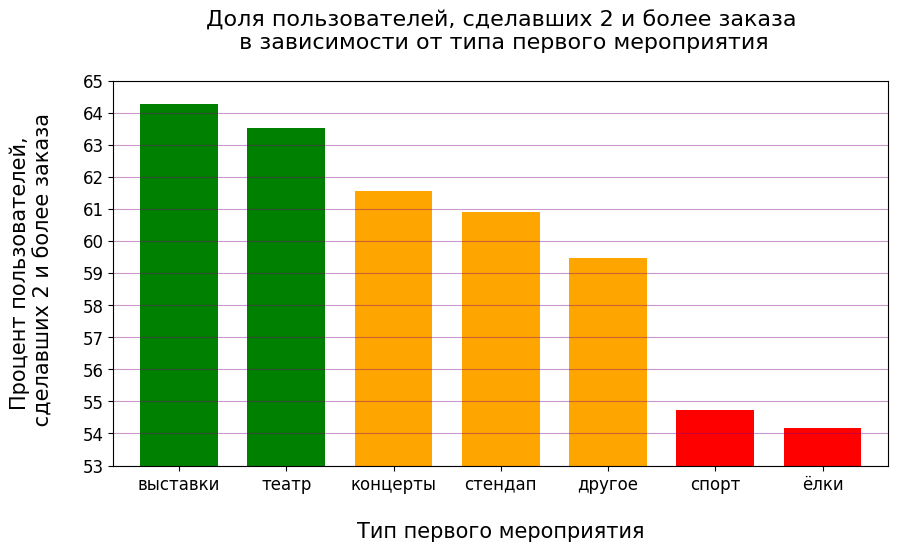

In [38]:
first_event_type = first_event_type.sort_values(
    'is_two_share', ascending=False).reset_index(drop=True)

title1 = (f'Доля пользователей, сделавших 2 и более заказа\n '
       f'в зависимости от типа первого мероприятия\n')

first_event_type.plot(
    kind='bar',
    figsize = (10,5),
    ylim = (53,65),
    legend = False,
    title = title1,
    x = 'first_event_type',
    y = 'is_two_share',
    rot = 0,
    fontsize = 12,
    width = 0.725,
    color = ['green','green','orange','orange',
             'orange','red','red']
)
plt.title(title1, fontsize=16)
plt.xlabel('\nТип первого мероприятия', fontsize = 15)
plt.ylabel('Процент пользователей,\n сделавших 2 и более заказа\n',fontsize=15)
plt.gca().yaxis.set_major_locator(MLoc(1))
plt.grid(alpha=0.4, axis='y', color='purple')
# Выводим график
plt.show() 

In [39]:
greater2_device = user_profile.groupby(
    'first_device')['is_two'].mean().reset_index()

greater2_device = greater2_device.rename(columns={'is_two': 'is_two_share'})
greater2_device['is_two_share'] = round(greater2_device['is_two_share'] * 100,2)

first_device_type = first_device_type.merge(
    greater2_device, on='first_device', how='left')

first_device_type

,first_device,user_count,share,is_two_share
0,mobile,17692,82.92,60.69
1,desktop,3643,17.08,63.63


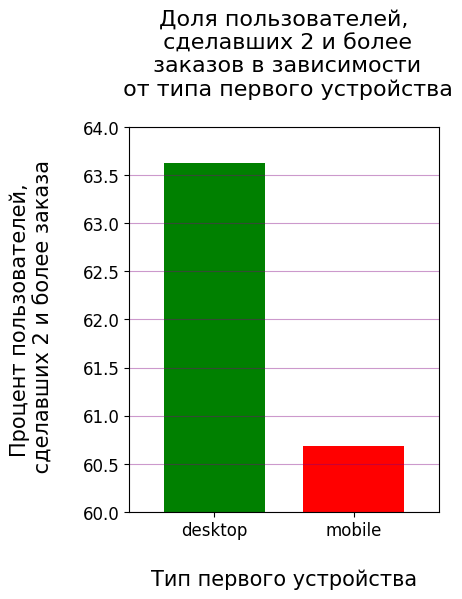

In [40]:
first_device_type = first_device_type.sort_values(
    'is_two_share', ascending=False).reset_index(drop=True)

title = (f'Доля пользователей,\n сделавших 2 и более\n заказов '
       f'в зависимости\n от типа первого устройства\n')

first_device_type.plot(
    kind='bar',
    figsize = (4,5),
    ylim = (60,64),
    legend = False,
    x = 'first_device',
    y = 'is_two_share',
    rot = 0,
    fontsize = 12,
    width = 0.725,
    color = ['green','red']
)
plt.title(title, fontsize=16)
plt.xlabel('\nТип первого устройства', fontsize = 15)
plt.ylabel('Процент пользователей,\n сделавших 2 и более заказа\n',fontsize=15)
plt.gca().yaxis.set_major_locator(MLoc(0.5))
plt.grid(alpha=0.4, axis='y', color='purple')
# Выводим график
plt.show() 

In [41]:
greater2_region = user_profile.groupby(
    'first_region')['is_two'].mean().reset_index()

greater2_region = greater2_region.rename(columns={'is_two': 'is_two_share'})
greater2_region['is_two_share'] = round(greater2_region['is_two_share'] * 100,2)

first_reg = first_reg.merge(
    greater2_region, on='first_region', how='left')

display(first_reg.head(10))
display(first_reg.tail(3))

,first_region,user_count,share,is_two_share
0,Каменевский регион,6945,32.55,61.76
1,Североярская область,3731,17.49,63.79
2,Широковская область,1226,5.75,64.60
3,Озернинский край,672,3.15,55.21
4,Малиновоярский округ,526,2.47,55.51
5,Шанырский регион,464,2.17,69.40
6,Светополянский округ,463,2.17,66.09
7,Травяная область,459,2.15,61.44
8,Речиновская область,444,2.08,63.74
9,Яблоневская область,408,1.91,60.05


,first_region,user_count,share,is_two_share
78,Верхозёрский край,1,0.0,100.0
79,Сосноводолинская область,1,0.0,0.0
80,Яснопольский округ,1,0.0,0.0


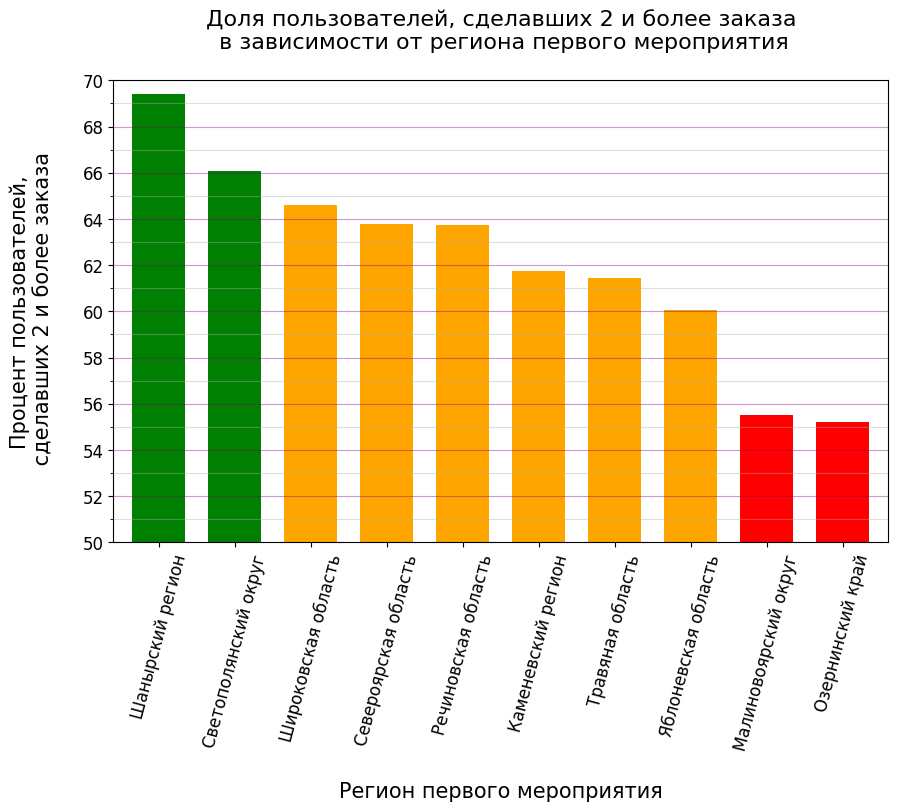

In [42]:
first_reg = first_reg.head(10)

first_reg = first_reg.sort_values(
    'is_two_share', ascending=False).reset_index(drop=True)

title1 = (f'Доля пользователей, сделавших 2 и более заказа\n '
       f'в зависимости от региона первого мероприятия\n')

first_reg.plot(
    kind='bar',
    figsize = (10,6),
    ylim = (50,70),
    legend = False,
    title = title1,
    x = 'first_region',
    y = 'is_two_share',
    rot = 75,
    fontsize = 12,
    width = 0.7,
    color = ['green','green','orange','orange','orange',
             'orange','orange','orange','red','red']
)
plt.title(title1, fontsize=16)
plt.xlabel('\nРегион первого мероприятия', fontsize = 15)
plt.ylabel('Процент пользователей,\n сделавших 2 и более заказа\n',fontsize=15)
plt.gca().yaxis.set_major_locator(MLoc(2))
plt.gca().yaxis.set_minor_locator(MLoc(1))
plt.grid(alpha=0.4, axis='y', color='purple')
plt.grid(alpha=0.4, axis='y', which='minor')
# Выводим график
plt.show() 

In [43]:
greater2_service = user_profile.groupby(
    'first_service')['is_two'].mean().reset_index()

greater2_service = greater2_service.rename(columns={'is_two': 'is_two_share'})
greater2_service['is_two_share'] = round(greater2_service['is_two_share'] * 100,2)

services = services.merge(
    greater2_service, on='first_service', how='left')

display(services.head(10))
display(services.tail(3))

,first_service,user_count,share,is_two_share
0,Билеты без проблем,4901,22.97,59.80
1,Мой билет,2979,13.96,60.42
2,Лови билет!,2795,13.10,61.14
3,Билеты в руки,2533,11.87,62.69
4,Облачко,2198,10.30,61.33
5,Весь в билетах,1276,5.98,62.46
6,Лучшие билеты,1174,5.50,61.75
7,Прачечная,587,2.75,63.03
8,Край билетов,461,2.16,64.86
9,Дом культуры,353,1.65,64.87


,first_service,user_count,share,is_two_share
31,Лимоны,2,0.01,50.0
32,Тех билет,2,0.01,50.0
33,Зе Бест!,1,0.00,100.0


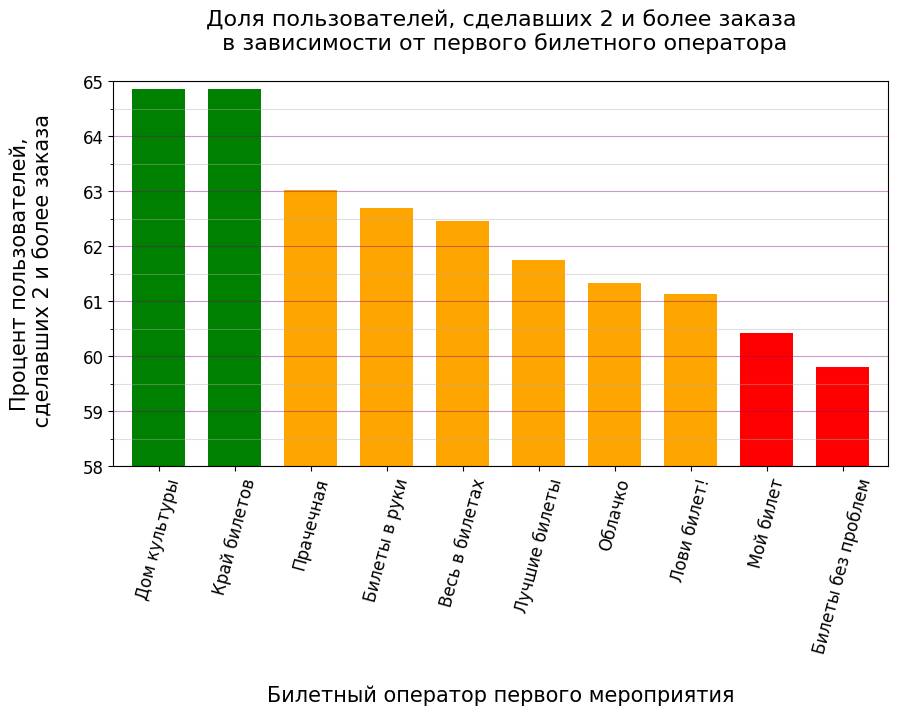

In [44]:
services = services.head(10)

services = services.sort_values(
    'is_two_share', ascending=False).reset_index(drop=True)

title1 = (f'Доля пользователей, сделавших 2 и более заказа\n '
       f'в зависимости от первого билетного оператора\n')

services.plot(
    kind='bar',
    figsize = (10,5),
    ylim = (58,65),
    legend = False,
    title = title1,
    x = 'first_service',
    y = 'is_two_share',
    rot = 75,
    fontsize = 12,
    width = 0.7,
    color = ['green','green','orange','orange','orange',
             'orange','orange','orange','red','red']
)
plt.title(title1, fontsize=16)
plt.xlabel('\nБилетный оператор первого мероприятия', fontsize = 15)
plt.ylabel('Процент пользователей,\n сделавших 2 и более заказа\n',fontsize=15)
plt.gca().yaxis.set_major_locator(MLoc(1))
plt.gca().yaxis.set_minor_locator(MLoc(0.5))
plt.grid(alpha=0.4, axis='y', color='purple')
plt.grid(alpha=0.4, axis='y', which='minor')
# Выводим график
plt.show() 

Чаще других возвращаются пользователи, у которых первый заказ был:

- с билетами в театр (~ 63.5%) и на выставки (~ 64.3%);
- сделан с компьютера (~ 63.6%);
- на мероприятие в Шанырском регионе (69.4 %) или Светополянском округе (~ 66,1%);
- приобретен у билетных операторов "Дом Культуры" и "Край билетов" (~ 64.9%).

---

**Задача 4.1.3.** Проверить продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1. По графикам видно, что тип первого мероприятия влияет на вероятность возврата на Яндекс Афишу. Например, пользователи, которые совершили первый заказ на спортивные меропиятия, совершают повторный заказ реже, чем пользователи, оформившие свой первый заказ на концерты (~ 54,7% против ~ 61,6%). 

Гипотеза не подтверждена.

Гипотеза 2. Два региона с наибольшим количеством заказов показывают средние показатели в топ-10 регионах по доле возвращающихся на платформу пользователей:
- Максимальное значение доли возвращающихся пользователей - 69,4 %);
- Каменевский район (топ-1 по количеству заказов) - ~ 61.8% вернувшихся пользователей;
- Североярская облать (топ-2 по количеству заказов) - ~ 63.8% вернувшихся пользователей;
- Минимальное значение доли возращающихся пользователей - 59,8%.

Гипотеза не подтверждена.

---

В этом разделе разбили пользователей на сегменты, определили точки входа. По типу мероприятия это концерты (около 45 %), по типу устройств - мобильные (почти 5/6), по району проведения мероприятия - Каменевский район (почти 1/3), по билетному оператору - "Билеты без проблем" (около 23 %).

К успешным точкам входа (клиент возращается в наблюдаемом периоде) можно отнести заказы с билетами в театр (~ 63.5%) и на выставки (~ 64.3%), на мероприятия в Шанырском регионе (69.4 %) или Светополянском округе (~ 66.1%), заказы сделаные на desktop устройствах (~ 63.6%) и заказы, приобретенные у билетных операторов "Дом Культуры" и "Край билетов" (~ 64.9%).

Также, проверили две гипотезы: "Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты." и "В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.". Обе гипотезы не подтвердились. Пользователи, которые совершили первый заказ на спортивные меропиятия, совершают повторный заказ реже, чем пользователи, оформившие свой первый заказ на концерты, а топ-2 региона по доле вернувшихся пользователей показывают средние результаты в топ-10 регионов по заказам. 

Важно отметить, что наблюдаемый период - 5 месяцев. Из-за этого показатели таких сегментов как "первый заказ - елки" может быть некорректен.

<a href="#cont" class="anchor">[Вернуться к содержанию]</a>

---
<a id="chapter42" class="anchor"></a>
#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

**Задача 4.2.1.** 

Построим сравнительные гистограммы распределения средней выручки с заказа 'avg_revenue_rub' для пользователей, совршивших один и более одного заказа:

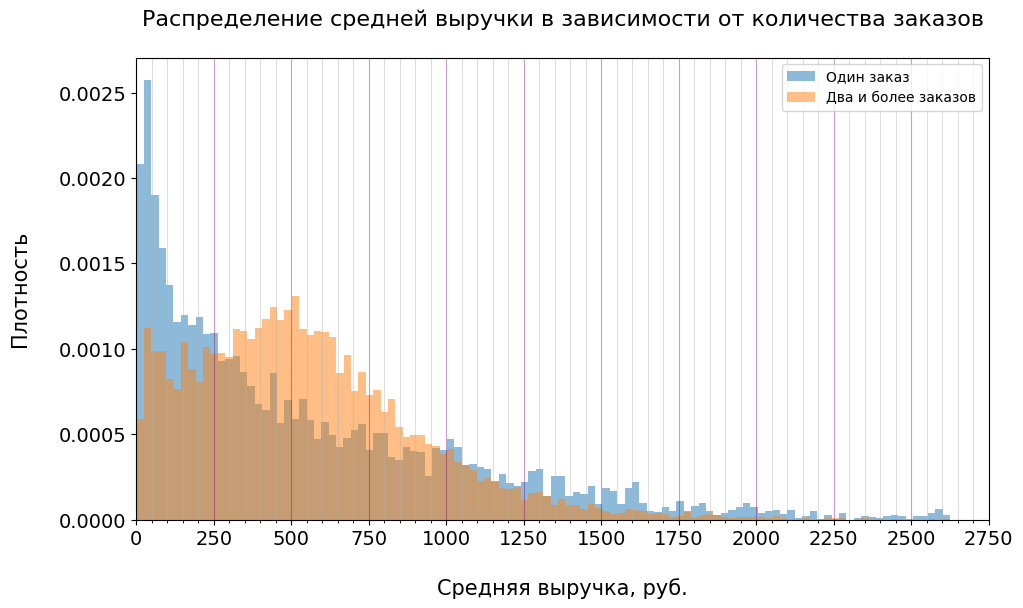

In [45]:
one_order = user_profile[user_profile['is_two'] == 0]
more_then_one_order = user_profile[user_profile['is_two'] == 1]

plt.figure(figsize=(11,6))

one_order['avg_revenue_rub'].plot(
    kind='hist',
    label ='Один заказ',                 
    alpha=0.5,
    bins=110, 
    density=True,
    xlim = (0,2750)
)
more_then_one_order['avg_revenue_rub'].plot(
    kind='hist',
    label ='Два и более заказов',                 
    alpha=0.5,
    bins=110,
    density=True,
    fontsize=14,
    xlim = (0,2750)
)
plt.gca().xaxis.set_major_locator(MLoc(250))
plt.gca().xaxis.set_minor_locator(MLoc(50))
plt.grid(alpha=0.4, axis='x', color='purple')
plt.grid(alpha=0.4, axis='x', which='minor')
plt.xlabel('\nСредняя выручка, руб.', fontsize = 15)
plt.ylabel('Плотность\n', fontsize = 15)
plt.title(
    'Распределение средней выручки в зависимости от количества заказов\n',
    fontsize = 16
)
plt.legend()
plt.show()

Основная часть значений средней выручки от пользователей с одним заказом сконцентрирована в диапазоне 0–250 руб., а для пользователей с двумя и более заказами — в диапазоне 50–700 руб. В то же время в области высоких значений (свыше 1000 руб.) пользователи с одним заказом встречаются чаще, чем пользователи с повторными покупками, что указывает на присутствие небольшой группы высокодоходных разовых клиентов.

---

**Задача 4.2.2.** 

Таким же образом построим сравнительные гистрограммы для двух групп пользователей

- Совершивших от 2 до 4 заказов;
- Совершивших 5 и более заказов.

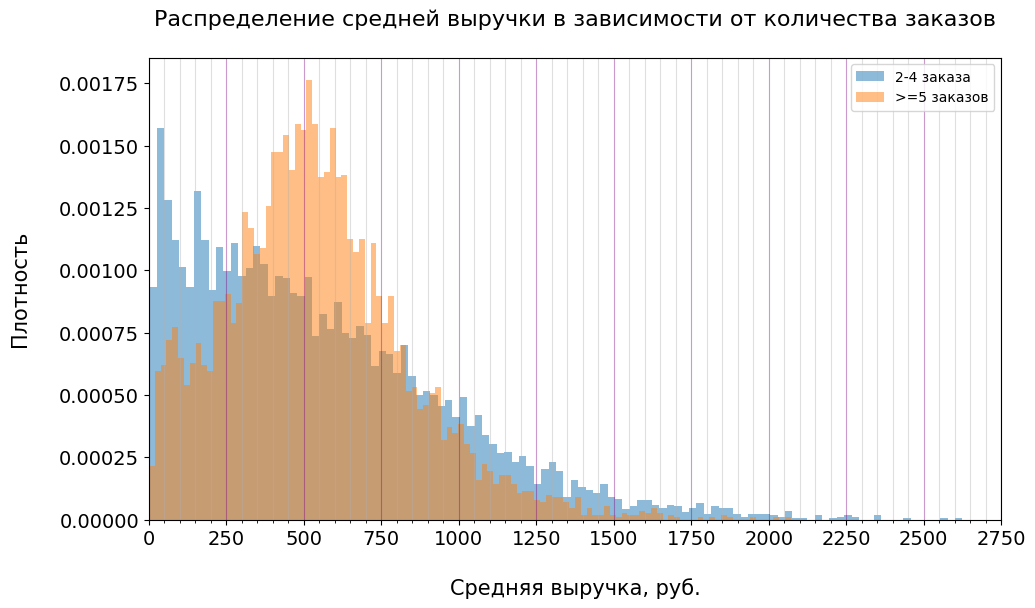

In [46]:
two_to_four_ord = user_profile[
    user_profile['is_two'] == 1 & 
    (user_profile['is_five'] == 0)]

five_plus_orders = user_profile[
    (user_profile['is_five'] == 1)]

plt.figure(figsize=(11,6))

two_to_four_ord['avg_revenue_rub'].plot(
    kind='hist',
    label ='2-4 заказа',                 
    alpha=0.5,
    bins=110, 
    density=True,
    xlim = (0,2750)
)
five_plus_orders['avg_revenue_rub'].plot(
    kind='hist',
    label ='>=5 заказов',                 
    alpha=0.5,
    bins=110,
    density=True,
    fontsize=14,
    xlim = (0,2750)
)
plt.gca().xaxis.set_major_locator(MLoc(250))
plt.gca().xaxis.set_minor_locator(MLoc(50))
plt.grid(alpha=0.4, axis='x', color='purple')
plt.grid(alpha=0.4, axis='x', which='minor')
plt.xlabel('\nСредняя выручка, руб.', fontsize = 15)
plt.ylabel('Плотность\n', fontsize = 15)
plt.title(
    'Распределение средней выручки в зависимости от количества заказов\n',
    fontsize = 16
)
plt.legend()
plt.show()

Основная часть значений средней выручки от пользователей в группе "2-4 заказа" сконцентрирована в диапазоне 0–500 руб., а для пользователей с пятью и более заказами — в диапазоне 200–800 руб. В то же время в области высоких значений (свыше 900 руб.) пользователи в группе "2-4 заказа" встречаются чаще, что указывает на наличие небольшой подгруппы высокодоходных клиентов с редкими повторными покупками.

---

**Задача 4.2.3.** Проанализируем влияние среднего количества билетов в заказе на вероятность повторной покупки.

1) Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе:

  - от 1 до 2 билетов;
  - от 2 до 3 билетов;
  - от 3 до 5 билетов;
  - от 5 и более билетов.

2) Для каждого сегмента подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы.

In [47]:
bins = [1, 2, 3, 5, 6] # max(avg_tickets) = 5 (см. задачу 3.2)
labels = ['1-2', '2-3', '3-5', '5+']
user_profile['ticket_segment'] = pd.cut(
    user_profile['avg_tickets'], 
    bins=bins, labels=labels, right=False
)

ticket_segment_t = user_profile.groupby('ticket_segment').agg(
    total_users=('user_id', 'count'),
    return_rate=('is_two', 'mean')
).reset_index()

ticket_segment_t['return_rate'] = round(
    ticket_segment_t['return_rate']*100,2)

display(ticket_segment_t)

C:\Users\puzho\AppData\Local\Temp\ipykernel_10116\819804209.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ticket_segment_t = user_profile.groupby('ticket_segment').agg(


,ticket_segment,total_users,return_rate
0,1-2,2417,51.47
1,2-3,9638,73.86
2,3-5,8817,52.78
3,5+,463,8.21


Реже всего возвращаются клиенты, у которых среднее число билетов в заказе больше 5 (~ 8.2%). Сегменты пользователей по среднему количеству билетов в заказе 1-2 и 3-5 возвращаются примерно в половине случаев (~ 51.4% и ~ 52.8%). Чаще всего возвращаются клиенты, у которых среднее число билетов в заказе от 2 до 3 (~ 73.9%).

---

В этом разделе сравнили распределение средней выручки с заказа:

- между пользователями, совершившими один и несколько заказов;
- между пользователями, совершившими 2-4 заказа и >=5 заказов.

Основная часть средней выручки пользователей с одним заказом сконцентрирована в диапазоне 0–250 руб., тогда как для пользователей с двумя и более заказами — в диапазоне 50–700 руб. Примечательно, что в области высоких значений (свыше 1000 руб.) разовые клиенты встречаются чаще повторных покупателей, что указывает на существование небольшой подгруппы высокодоходных, но нелояльных клиентов.

По мере увеличения частоты покупок распределение выручки становится более предсказуемым. Для пользователей с двумя и более заказами распределение приближается к нормальному, а для группы с 5+ заказами оно значительно сужается — уменьшается стандартное отклонение.

После исследовали влияние среднего количества билетов в заказе на вероятность повторной покупки. Реже всего, примерно в 8 % случаев, возращаются пользователи, сделавшие заказ на 5 и более билетов, а чаще всего (около 74%) группа пользователей со среднем количеством билетов в заказах 2-3 - видимо это сегмент пар и небольших компаний. Сегменты пользователей со средним количеством билетов от 1 до 2, либо от 3 до 5 возвращаются примерно в половине случаев.

<a href="#cont" class="anchor">[Вернуться к содержанию]</a>

---
<a id="chapter43" class="anchor"></a>
#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучим временные параметры, связанные с первым заказом пользователей:

---

**Задача 4.3.1.** Проанализируем, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

---

In [48]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                 'Friday', 'Saturday', 'Sunday']

user_profile['first_weekday'] = user_profile['first_order'].dt.day_name()

weekday_stats = user_profile.groupby('first_weekday').agg({
    'user_id': 'count',
    'total_orders': lambda x: (x >= 2).mean()
}).round(4)

weekday_stats.columns = ['total_users', 'return_rate']

weekday_stats['return_rate'] = (weekday_stats['return_rate'] * 100).round(2)
weekday_stats = weekday_stats.reindex(order)
weekday_stats

,total_users,return_rate
first_weekday,,
Monday,2874,62.14
Tuesday,3126,61.64
Wednesday,3039,62.26
Thursday,3085,59.51
Friday,3209,59.74
Saturday,3271,62.73
Sunday,2731,60.23


Различные показатели влияния дня недели первого заказа на возврат пользователя к услугам сервиса носят, скорее всего, случайный порядок (59.51-62.73%).

---

**Задача 4.3.2.** Изучим, как средний интервал между заказами влияет на удержание клиентов.

---

Рассчитайте среднее время между заказами для двух групп пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

In [49]:
print(f'Среднее время между заказами для пользователей, совершивших\n'
      f'2-4 заказа в период наблюдения:        '
      f"{round(two_to_four_ord['avg_days_between_orders'].mean(),1)} дней,\n"
      f'5 и более заказов в период наблюдения:  '
      f"{round(five_plus_orders['avg_days_between_orders'].mean(),1)} дней")


Среднее время между заказами для пользователей, совершивших
2-4 заказа в период наблюдения:        21.1 дней,
5 и более заказов в период наблюдения:  9.9 дней


Исследуем как средний интервал между заказами влияет на вероятность повторного заказа:

Отфильтруем таблицу заказов: оставим в ней пользователей с тремя и более заказов (т.к нет "среднего" интервала между первым и вторым заказом). Для корректного расчета среднего интервала между заказами присоединим столбец с датой первого заказа пользователей из user_profile, пронумеруем заказы пользователей, удалим первые два заказа каждого пользователя.

Добавим бинарный признак 'is_next_order'. 'next_order_number' - сдвинутый на -1 'order_number'. Проводя сравнение, равно ли значение ('order_number' + 1) значению 'next_order_number', узнаем был ли у пользователя следующий заказ.

Столбец 'avg_days' подсчитывает средний интервал между заказами: (дата заказа - дата первого заказа)/(номер заказа - 1)

Для построения графика округлим значение avg_days до целых чисел. Построим столбчатую диаграмму, где для каждого целого найденного avg_days будет посчитана вероятность возврата пользователя is_next_order.mean().

In [50]:
is_3_users = user_profile[
    user_profile['total_orders'] >= 3]['user_id'].to_list()
dff = df[df['user_id'].isin(is_3_users)][
    ['user_id','order_dt','created_ts_msk']]

dff = pd.merge(
    dff, user_profile[['user_id', 'first_order']], 
on = 'user_id', how = 'inner')

dff['order_number'] = dff.groupby('user_id').cumcount() + 1
dff = dff[dff['order_number'] > 2]
dff['next_order_number'] = dff['order_number'].shift(-1)

dff['is_next_order'] = (
    dff['order_number'] + 1 == dff['next_order_number']).astype(int)

dff = dff.drop('next_order_number', axis=1)

dff['avg_days'] = (
    dff['order_dt'] - dff['first_order']).dt.days / (dff['order_number'] - 1)

dff['avg_days'] = dff['avg_days'].round()

display(dff.head(16))

,user_id,order_dt,created_ts_msk,first_order,order_number,is_next_order,avg_days
2,000898990054619,2024-10-23,2024-10-23 15:12:00,2024-07-13,3,0,51.0
5,000cf0659a9f40f,2024-06-20,2024-06-20 10:51:10,2024-06-20,3,1,0.0
6,000cf0659a9f40f,2024-06-20,2024-06-20 10:56:16,2024-06-20,4,1,0.0
7,000cf0659a9f40f,2024-06-20,2024-06-20 12:40:27,2024-06-20,5,1,0.0
8,000cf0659a9f40f,2024-06-20,2024-06-20 12:42:12,2024-06-20,6,1,0.0
9,000cf0659a9f40f,2024-06-20,2024-06-20 12:46:11,2024-06-20,7,1,0.0
10,000cf0659a9f40f,2024-06-20,2024-06-20 12:47:22,2024-06-20,8,1,0.0
11,000cf0659a9f40f,2024-06-21,2024-06-21 04:18:44,2024-06-20,9,1,0.0
12,000cf0659a9f40f,2024-06-21,2024-06-21 04:33:56,2024-06-20,10,1,0.0
13,000cf0659a9f40f,2024-06-21,2024-06-21 04:34:58,2024-06-20,11,1,0.0


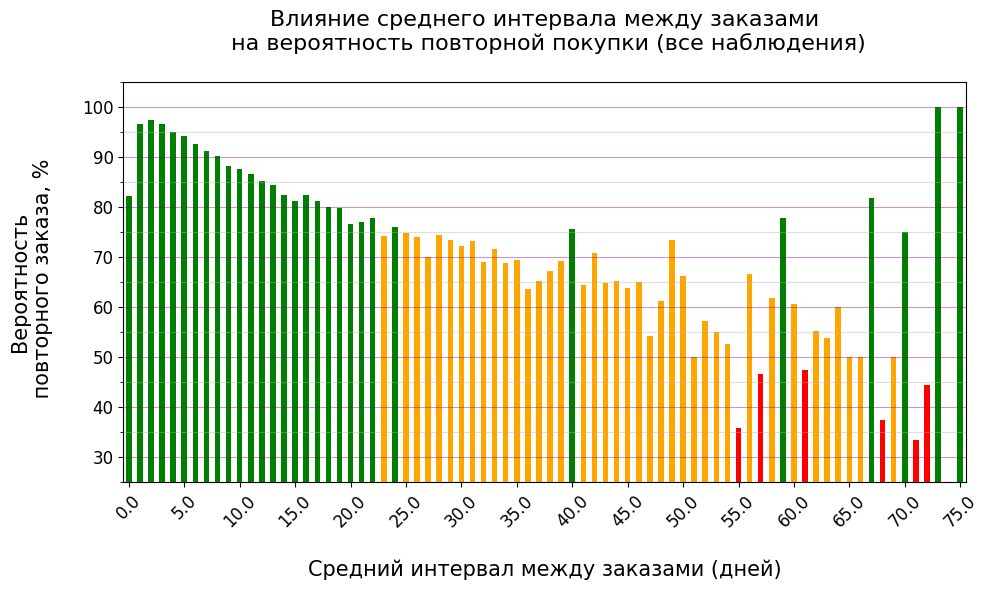

In [51]:
def get_color(value):
    if value >= 75:
        return 'green'
    elif value >= 50:
        return 'orange'
    else:
        return 'red'

result = dff.groupby('avg_days')['is_next_order'].agg(['mean', 'count'])
result = result[result['count'] >= 0]['mean'] * 100
colors = [get_color(val) for val in result.values]

# Строим график
result.plot(
    kind='bar',
    figsize=(10, 6),
    legend=False,
    rot=45,
    fontsize=12,
    width=0.5,
    color=colors
)

title = ('Влияние среднего интервала между заказами\n '
         'на вероятность повторной покупки (все наблюдения)\n')

plt.title(title, fontsize=16)
plt.xlabel('\nСредний интервал между заказами (дней)', fontsize=15)
plt.ylabel('Вероятность\n повторного заказа, %\n', fontsize=15)
plt.ylim(25, 105)
plt.gca().xaxis.set_major_locator(MLoc(5))
plt.gca().yaxis.set_major_locator(MLoc(10))
plt.gca().yaxis.set_minor_locator(MLoc(5))
plt.grid(alpha=0.4, axis='y', color='purple')
plt.grid(alpha=0.4, axis='y', which='minor')
plt.tight_layout()
plt.show()

Анализ показывает четкий тренд: с увеличением среднего интервала между покупками (до ~35 дней) вероятность повторного заказа снижается. После значения 35 дней тренд теряется и вероятность возрастает до 100%, но это, вероятно, связано с недостатком данных.

Гипотеза: при интервале наблюдения ~150 дней мог найтись 1 или 2 пользователя, которые совершили третью и четвертую покупки в конце октября.

In [52]:
print(f'Пользователей со средним периодом между покупками 75 дней:'
      f" {dff[dff['avg_days'] == 75]['user_id'].count()}")

Пользователей со средним периодом между покупками 75 дней: 1


Посмотрим распределение количества наблюдений для значений 'avg_days'

In [53]:
result = dff.groupby('avg_days')['is_next_order'].agg(['mean', 'count'])
print(result['count'].describe())

count       76.000000
mean      1332.144737
std       3034.525411
min          1.000000
25%         34.250000
50%        132.000000
75%        824.750000
max      17969.000000
Name: count, dtype: float64


Решение: Отфильтруем данные, оставив только avg_days с количеством наблюдений не меньше 1% от максимального (180).

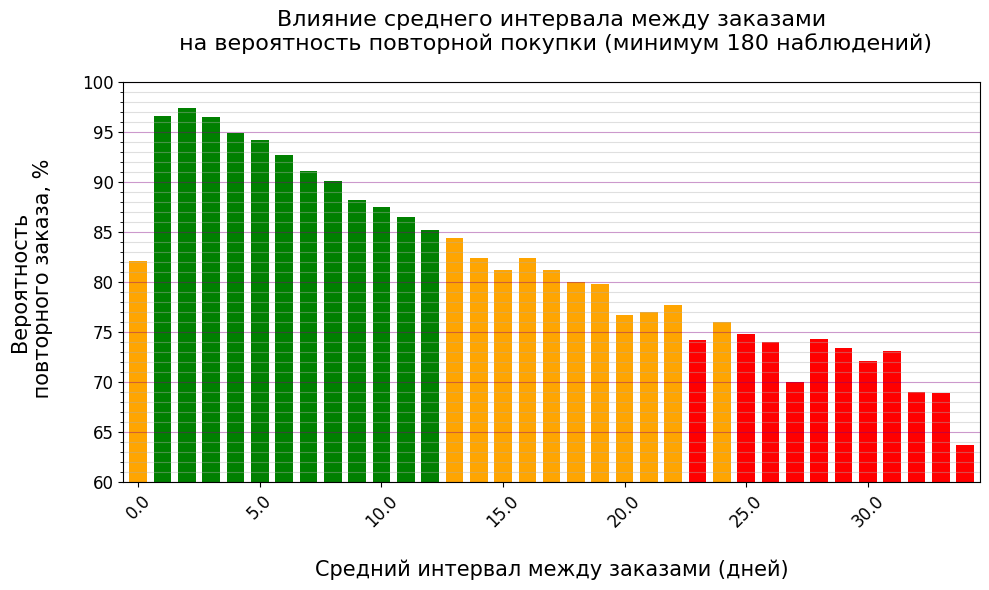

In [54]:
def get_color(value):
    if value >= 85:
        return 'green'
    elif value >= 75:
        return 'orange'
    else:
        return 'red'

# Применяем к данным
result = dff.groupby('avg_days')['is_next_order'].mean() * 100


result = dff.groupby('avg_days')['is_next_order'].agg(['mean', 'count'])
result = result[result['count'] >= 180]['mean'] * 100
colors = [get_color(val) for val in result.values]

# Строим график
result.plot(
    kind='bar',
    figsize=(10, 6),
    legend=False,
    rot=45,
    fontsize=12,
    width=0.725,
    color=colors
)

title = ('Влияние среднего интервала между заказами\n '
         'на вероятность повторной покупки (минимум 180 наблюдений)\n')

plt.title(title, fontsize=16)
plt.xlabel('\nСредний интервал между заказами (дней)', fontsize=15)
plt.ylabel('Вероятность\n повторного заказа, %\n', fontsize=15)
plt.ylim(60, 100)
plt.gca().xaxis.set_major_locator(MLoc(5))
plt.gca().yaxis.set_major_locator(MLoc(5))
plt.gca().yaxis.set_minor_locator(MLoc(1))
plt.grid(alpha=0.4, axis='y', color='purple')
plt.grid(alpha=0.4, axis='y', which='minor')
plt.tight_layout()
plt.show()

Вероятность повторного заказа снижается при увеличении среднего интервала между заказами от 1 (~ 95,5 %) до 34 дней (~ 63,8 %).
Вероятность ниже, если средний интервал между заказами 0 дней, что указывает, на "разовых" пользователей, которые докупали билеты. Определение вероятность возврата пользователя при среднем интервале между заказами > 34 дней будет недостоверно: из-за периода наблюдения (июнь-октябрь 2024 г) и как следствие и малого количества наблюдений (< 1% от максимального).

---

В этом разделе посчитали средний интервал между заказами пользователей с 2-4 заказами в период наблюдения и с 5 и более заказами в период наблюдения. Группа с "2-4 заказами" совершает покупки в среднем раз в 3 недели, а группа "5+ заказов" раз в 10 дней.

Рассчитали вероятность повторного заказа в зависимости от среднего интервала между покупками. При среднем интервале 0 дней, вероятность повторного заказа около 82%, максимум наблюдается при среднем интервале 2 дня (> 96%) и затем плавно спадает до значения ~ 64% при среднем интервале 34 дня. Отслеживание вероятности при среднем интервале > 34 дней нецелесообразно из-за малого количества наблюдений.

<a href="#cont" class="anchor">[Вернуться к содержанию]</a>

---
<a id="chapter44" class="anchor"></a>
#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучим, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используем универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:**

In [ ]:
# Вычисляем корреляционную матрицу с использованием phi_k:
corr_m = user_profile[['first_order', 'last_order', 'first_device',
                       'first_region', 'first_service', 'first_event_type',
                       'total_orders', 'avg_revenue_rub', 'avg_tickets',
                       'avg_days_between_orders']].phik_matrix(interval_cols= [
    'total_orders','avg_revenue_rub','avg_tickets','avg_days_between_orders'])

display(corr_m.loc[corr_m.index != 'total_orders'][
    ['total_orders']].sort_values(by='total_orders', ascending=False))

Обнаружены значения близкие к 0, которые, предположительно, не должны быть таковыми. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделим сегменты пользователей по полю total_orders, а затем повторим корреляционный анализ. Выделим такие сегменты:

- 1 заказ;
- от 2 до 4 заказов;
- от 5 и выше.

In [ ]:
user_profile['user_orders_cat']=pd.cut(
    x=user_profile['total_orders'], 
    bins=[0,1,4,150], # max orders = 150 (см. задачу 3.2)
    labels=['1 заказ','2-4 заказа','5+ заказов'])

# Вычисляем корреляционную матрицу с использованием phi_k:
corr_m = user_profile[['first_order', 'last_order', 'first_device',
                       'first_region', 'first_service', 'first_event_type',
                       'avg_revenue_rub', 'avg_tickets', 'user_orders_cat',
                       'avg_days_between_orders']].phik_matrix(interval_cols= [
    'avg_revenue_rub','avg_tickets','avg_days_between_orders'])

data_heatmap = corr_m.loc[corr_m.index != 'user_orders_cat'][
    ['user_orders_cat']].sort_values(by='user_orders_cat', ascending=False)

plt.figure(figsize=(3.5, 5.5))

title = ('Тепловая карта\nкоэффициента phi_k\n между total_orders и\n\
        признаками\nпрофиля пользователя')

sns.heatmap(data_heatmap,
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            linewidths=0.5,
            cbar=False
           )
plt.title(title, fontsize = 16)
plt.yticks(rotation=0, fontsize = 14)
plt.xlabel('Всего заказов', fontsize = 14)
# Выводим график
plt.show()

Проверим самую сильную связь:

In [ ]:
result = user_profile.groupby('user_orders_cat')['avg_tickets'].agg(['mean', 'count'])
result_sorted = result.sort_values('mean', ascending=False)

plot_data = result_sorted[['mean']].reset_index()
plot_data.columns = ['user_orders_cat', 'avg_tickets']

colors = ['green', 'orange', 'red']  

title1 = ('Среднее количество билетов в заказе\n'
          'в зависимости от количества заказов пользователя\n')

plot_data.plot(
    kind='bar',
    figsize=(10, 5),
    legend=False,
    title=title1,
    x='user_orders_cat',
    y='avg_tickets',
    rot=0,
    fontsize=12,
    width=0.7,
    color=colors
)

plt.title(title1, fontsize=16)
plt.xlabel('\nГруппы пользователей по количеству заказов', fontsize=15)
plt.ylabel('Среднее количество билетов\n в одном заказе\n', fontsize=15)
plt.ylim(2.68,2.71)
plt.gca().yaxis.set_major_locator(MLoc(0.01))
plt.gca().yaxis.set_minor_locator(MLoc(0.002))
plt.grid(alpha=0.4, axis='y', color='purple')
plt.grid(alpha=0.4, axis='y', which='minor')

# Выводим график
plt.show()

Сильная корреляционная связь между количеством заказов (по группам) и среднем количеством билетов в заказе подтверждается, однако среднее значение количества билетов в заказе мало отличаются друг от друга.

---

В данном разделе вычислили матрицу phi_k корреляции между количеством заказов и признаками профиля пользователя:

1) Средним количеством билетов в заказе;

2) Датой первого заказа;

3) Датой последнего заказа;

4) Средним количеством дней между заказами;

5) Средней выручкой с заказа (в рублях);

6) Регионом проведения первого для пользователя мероприятия;

7) Билетным сервисом, с помощью которого куплены билеты первого заказа;

8) Типом устройства, с которого сделан первый заказ;

9) Типом мероприятия, который для пользователя был первым.

Самую сильную корреляцию показывает среднее количество билетов в заказе (0.658). 

Признаки дат первого и последнего заказа также показывают сильную связь (при равной периодичности заказов суммарное количество заказов будет тем больше, чем больше разнесены даты первого и последнего заказа).

Признак среднего количества дней между заказами показывает среднюю корреляционную связь с количеством заказов (при равных периодах активности пользователей "всего заказов" будет тем больше, чем меньше показатель периодичности заказов).

Первый для пользователя регион проведения и тип мероприятия, а также билетный сервис не оказывают существенного влияния на общее число заказов.

Тип устройства, с которого пользователь сделал первый заказ, практически не влияет на количество купленных билетов в будущем.

<a href="#cont" class="anchor">[Вернуться к содержанию]</a>

---

<a id="chapter50" class="anchor"></a>
### 5. Общий вывод и рекомендации

В данном проекте искали пользователей Яндекс Афиши, которые чаще остальных возвращаются в сервис.

Использовалась БД "Афиши" заказов в России и Казахстане за период июнь-октябрь 2024 года. В расчетах ислледования не приняли участие записи:

- Сделанные с устройств, отличных от ПК и мобильных (~ 0.4% записей БД)
- Заказов с билетами на фильмы (19 записей БД)

Проведена дополнительная фильтрация:

- Из анализа исключены записи с нулевой или отрицательной выручкой (подарки, возвраты)
- Убраны записи, с аномальными выручкой за заказ и количеством билетов в заказе, а также записи заказов пользователей с аномальным количество заказов (>1/день). 
- Убраны записи неявных дубликатов

Записей, загруженных из БД - 290611, записей (заказов) после предобработки и построения профилей пользователей целевой аудитории - 135633 (~ 48,9%). 

Точки входа: концерты (~ 45%), мобильные телефоны (~ 83%), мероприятия в Каменевском районе (~ 32,5 %), сервис "Билеты без проблем" (~23 %).

Наибольшие доли вернувшихся клиентов при первом заказе: 

- с билетами в театр (~ 63.5%) и на выставки (~ 64.3%);
- сделан с компьютера (~ 63.6%);
- на мероприятие в Шанырском регионе (69.4 %) или Светополянском округе (~ 66,1%);
- приобретен у билетных операторов "Дом Культуры" и "Край билетов" (~ 64.9%).

Распределение средней выручки для пользователей с одним заказом сконцентрирована в диапазоне 0–250 руб. С увеличением количества заказов средняя выручка стремится к значению 550 руб, а ее стандартное отклонение уменьшается.

Установлено, что чаще всего повторно покупают билеты пользователи со средним количеством билетов в заказе равным от 2 до 3 (~ 74 %). Реже всего возращаются пользователи, сделавшие заказ с пятью и более билетами (~ 8%). Cегменты пользователей со средним количеством билетов от 1 до 2, либо от 3 до 5 возвращаются примерно в половине случаев.

Интервалы между покупками влияют на возврат пользователей. Чем выше интервал, тем меньше вероятность, что пользователь сделает следующую покупку. При среднем интервале между покупками 1-3 дня, пользователи возращаются в > 95% случаев, при среднем интервале 25-33 дня процент возвращающихся пользователей 65-75%. Исключением служит средний интервал 0 дней (~ 82%). Впрочем, это могут быть разовые покупатели, забывшие или докупающие билеты.

Согласно проведенному корреляционному анализу самую сильную корреляцию с общим числом заказов показывают: среднее количество билетов в заказе, даты первого и последнего заказов, среднее количество дней между заказами.

Рекомендуется:

- развивать в сервисе продажу билетов на выставки. При текущей доле 2% заказов в сервисе, такие пользователи чаще всего совершеают повторные покупки (~ 63.5%).
- развивать сотрудничество с билетными операторами "Мои культуры" и "Край билетов". Доля возвращюхся пользователей, сделавших первый заказ через этих операторов приближается к 65% (возможно, молодой сервис, привлекающий клиентов скидками, стоит проверить).
- рассмотреть возможность улучшения функционала сайта. Хотя около 5/6 пользователей делает первые заказы через мобильные устройства, доля покупателей, возвращаюхся к услугам сервиса после первого заказа с desktop-устройств выше.
- рассмотреть возможно внедрения алгоритма отслеживания времени последней покупки пользователя. При достижении какого либо порогового значения вероятности, стимулировать пользователя вернуться к услугам сервиса.
- рассмотреть возможность стимулировать жителей Шанырского региона, возможно, предложением скидки на первый заказ и т.д. Их доля в заказах пока небольшая (~ 2.2%), но процент возратов почти 70 процентов.

<a href="#cont" class="anchor">[Вернуться к содержанию]</a>

---